In [3]:
import os
from matplotlib import pyplot as plt
import matplotlib.pylab as pl
import numpy as np
os.chdir('/Users/rraj/PythonFunctions/DCNet/')
os.getcwd()

'/Users/rraj/PythonFunctions/DCNet'

In [4]:
import torch
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
from tqdm import tqdm

mnist_data = MNIST(
    root = 'data',
    train = True,                         
    transform = transforms.ToTensor(), 
    download = True,            
)


In [67]:
def pad_one_hot(x: torch.Tensor, label: torch.Tensor, num_classes: int, teaching: bool=False):
    assert x.dim() == 2 and x.shape[0] == 1, "input must be a row vector"
    one_hot_rep = torch.unsqueeze(F.one_hot(label, num_classes=num_classes), 0) if teaching else torch.zeros(1, num_classes)
    return torch.cat((x, one_hot_rep), dim=1)


n_data = len(mnist_data.targets)
data_dim = mnist_data.data[0].shape
n_samples = int(0.15*n_data)
mnist_sample_data = torch.empty(n_samples, data_dim[0]*data_dim[1]+10)

for i in tqdm(range(n_samples)):
    idx = torch.squeeze(torch.randint(0, n_data, (1,)))
    mnist_sample_data[i,:] = pad_one_hot(torch.unsqueeze(torch.flatten(mnist_data.data[idx]/255), 0), mnist_data.targets[idx], 10)



100%|██████████| 9000/9000 [00:00<00:00, 21895.46it/s]


In [6]:

from initialization import initialize_connections
from layers import DiscriminationModule, ClassificationModule
from plotting import plot_clusters, plot_connections

In [74]:
weights = initialize_connections(mnist_sample_data, 1000)
module_d = DiscriminationModule(weights, lr=0.95, alpha=1.5)
module_c = ClassificationModule(torch.eye(1000))

for i in tqdm(range(2000)):
    idx = torch.squeeze(torch.randint(0, n_data, (1,)))
    x = pad_one_hot(torch.unsqueeze(torch.flatten(mnist_data.data[idx]/255), 0), mnist_data.targets[idx], 10, teaching=torch.rand(1).item() < 1)
    y_ = module_d(x)
    module_c(y_)

    module_d.organize() if i > 0 and i%50 == 0 else None 
    module_c.organize() if i > 0 and i%200 == 0 else None


  5%|▌         | 107/2000 [01:40<30:02,  1.05it/s]

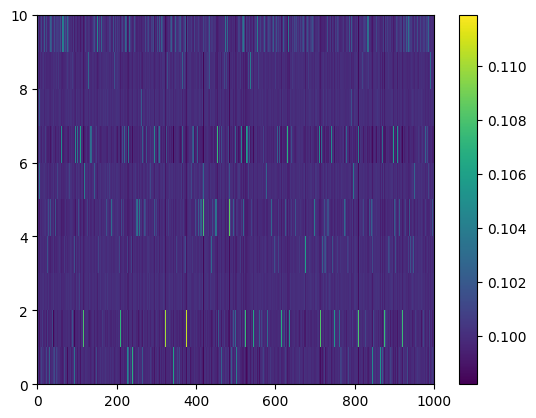

In [69]:
from torch import nn
smax = nn.Softmax(dim=0)
plt.pcolormesh(smax(module_d.connections()[784:,:]))
plt.colorbar()

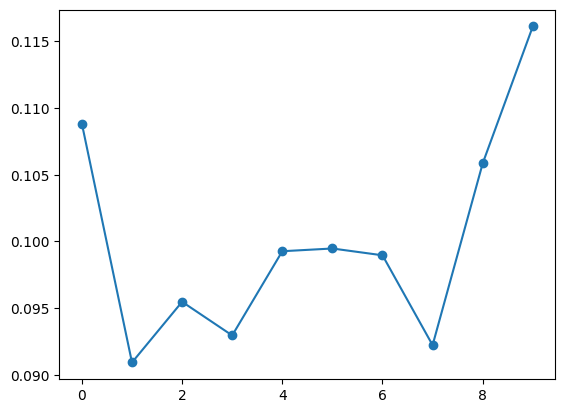

In [20]:
plt.plot(smax(module_d.connections()[784:,:])[:,15], "o-")

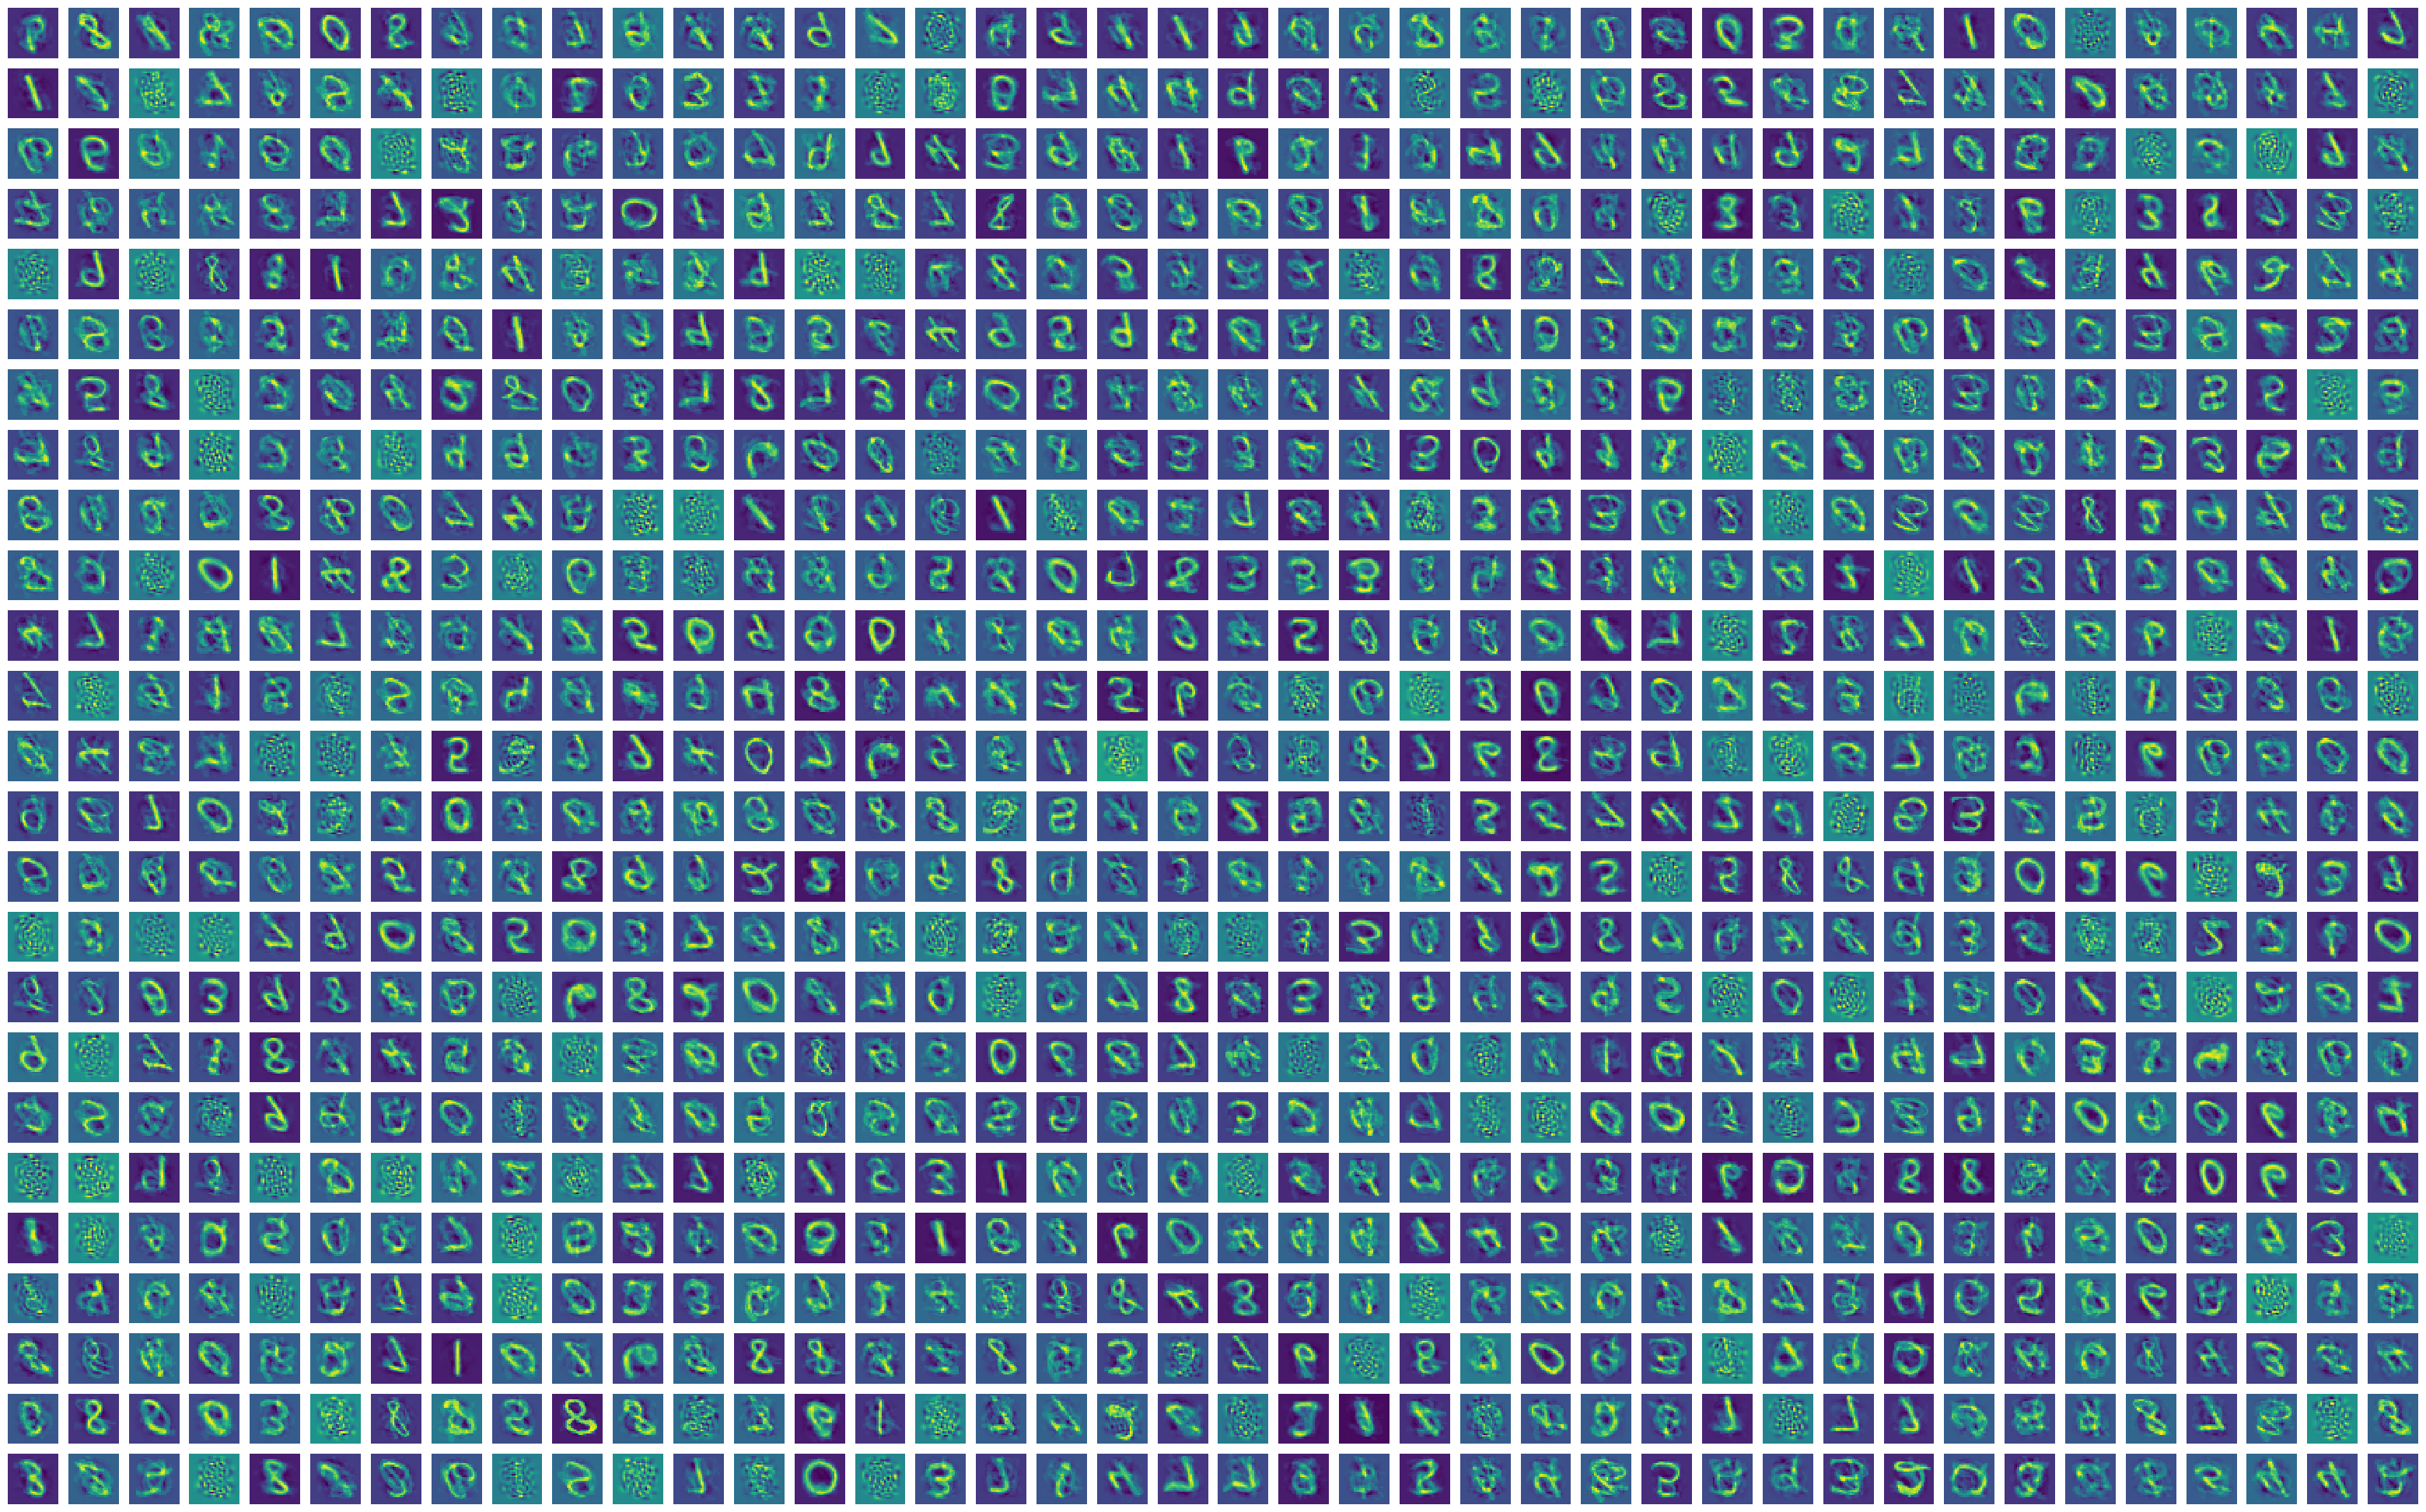

In [13]:
plot_connections(module_d.connections()[:784,:])

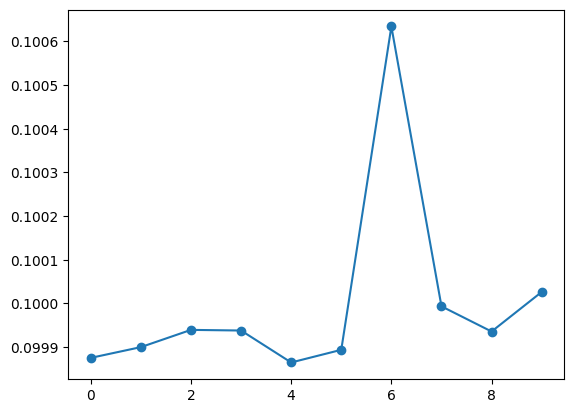

In [73]:
plt.plot(smax(module_d.connections()[784:,:])[:,9], "o-")

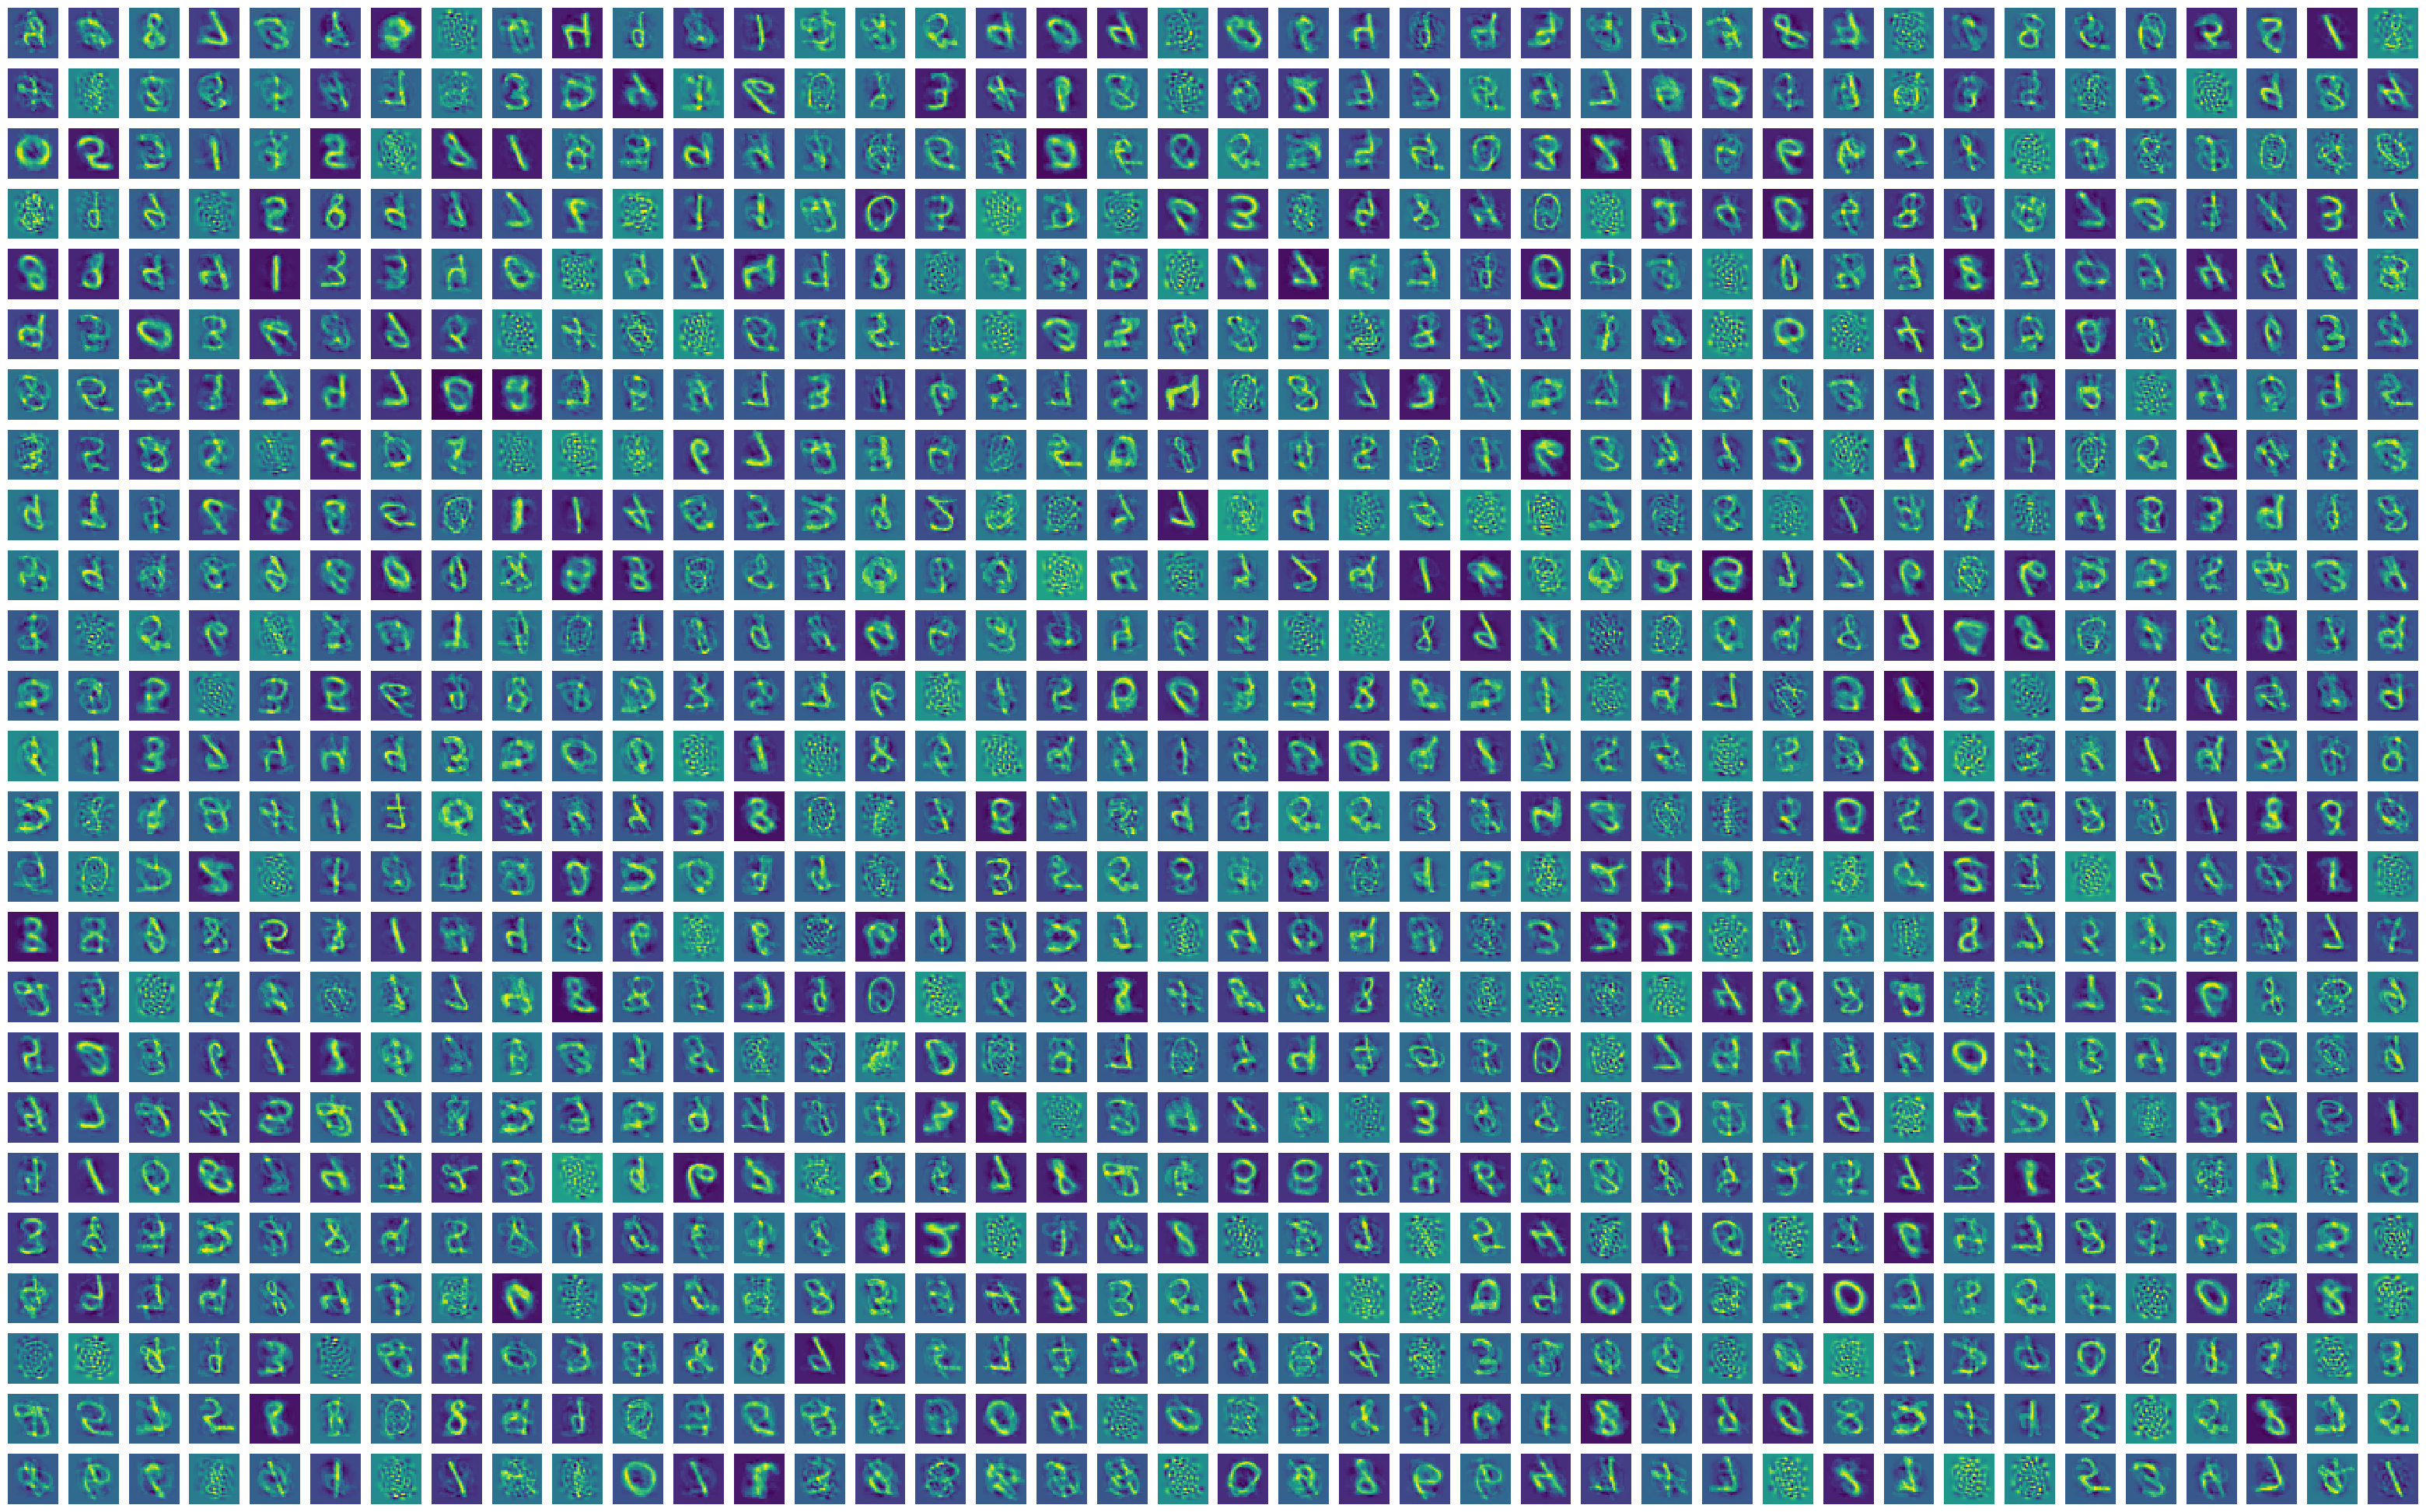

In [70]:
plot_connections(module_d.connections()[:784,:])